In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/cis/home/dpacker/my_documents/vote-counts


In [48]:
import pandas as pd
from pathlib import Path
import numpyro
import jax
from numpyro import distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
from jax import random, numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import os
from numpyro.contrib.funsor import config_enumerate, infer_discrete
from src import preprocessing

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

path_data = Path("data")
path_raw_data = path_data / "raw_data"

In [3]:
raw_data = pd.read_csv(path_raw_data / "Local_2018.csv")
data = preprocessing.preprocess(raw_data)
elections_dict = preprocessing.get_elections_dict(data)

/tmp/ipykernel_996634/3180180344.py:1: DtypeWarning: Columns (2,3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(path_raw_data / "Local_2018.csv")


In [4]:
county_id = list(elections_dict.keys())[500]
county_elections = elections_dict[county_id]

In [5]:
example_election = county_elections["CITY COUNCIL - MT. OLIVET"]
def model_B1(n_choices = None, total_votes = None, votes = None):
  vote_probs = numpyro.sample("vote_probs", dist.Dirichlet(jnp.full(shape=[n_choices], fill_value = 1.)))
  observed_votes = numpyro.sample("observed_votes", dist.Multinomial(total_count = total_votes, probs = vote_probs), obs=votes)

In [6]:
total_votes = example_election['votes'].sum()
n_choices = len(example_election)
votes = jnp.array(example_election["votes"])

In [7]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_B1)
num_samples = 2_000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, n_choices = n_choices, total_votes = total_votes, votes = votes
)
mcmc.print_summary()
samples_B1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:05<00:00, 500.54it/s, 7 steps of size 9.16e-01. acc. prob=0.89] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
vote_probs[0]      0.26      0.03      0.26      0.21      0.31   1809.16      1.00
vote_probs[1]      0.31      0.03      0.30      0.25      0.36   2316.02      1.00
vote_probs[2]      0.24      0.03      0.24      0.19      0.29   2284.17      1.00
vote_probs[3]      0.19      0.03      0.19      0.14      0.24   2231.36      1.00

Number of divergences: 0


<Axes: ylabel='Count'>

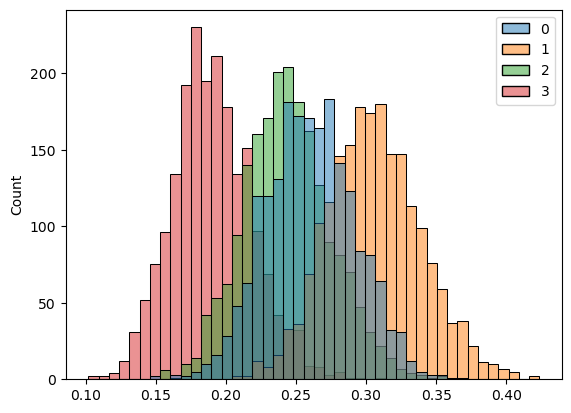

In [8]:
sns.histplot(samples_B1['vote_probs'])

In [65]:
num_votes_list = []
num_candidates_list = []
votes_list = []

for key, elect_df in county_elections.items():
    elect_df = elect_df.sort_values("votes", ascending=False).iloc[:2]
    votes = jnp.array(elect_df["votes"])
    num_votes = jnp.sum(votes)
    num_candidates = len(votes)

    votes_list.append(votes)
    num_votes_list.append(num_votes.item())
    num_candidates_list.append(num_candidates)

votes_array = jnp.stack(votes_list)
num_votes_array = jnp.array(num_votes_list)
num_candidates_array = jnp.array(num_candidates_list)

In [75]:
def model_B2(num_votes_array = None, votes_array = None):
  alpha = numpyro.sample("alpha", dist.Exponential(rate = 1.0))
  with numpyro.plate("election", len(num_votes_array)) as election:
    vote_probs = numpyro.sample("vote_probs", dist.Dirichlet(jnp.full([2], alpha)))
    observed_votes = numpyro.sample("observed_votes", dist.Multinomial(total_count = num_votes_array[election], probs = vote_probs), obs=votes_array[election])


In [76]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_B2)
num_samples = 2_000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_,
    num_votes_array=num_votes_array,
    votes_array=votes_array,
)
mcmc.print_summary()
samples_B2 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 393.91it/s, 3 steps of size 7.60e-01. acc. prob=0.89]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          alpha      2.97      1.65      2.65      0.62      5.32   2514.66      1.00
vote_probs[0,0]      0.44      0.05      0.44      0.35      0.53   2581.55      1.00
vote_probs[0,1]      0.56      0.05      0.56      0.47      0.65   2581.55      1.00
vote_probs[1,0]      0.47      0.04      0.47      0.41      0.53   2817.98      1.00
vote_probs[1,1]      0.53      0.04      0.53      0.47      0.59   2817.98      1.00
vote_probs[2,0]      0.44      0.05      0.43      0.35      0.53   2446.80      1.00
vote_probs[2,1]      0.56      0.05      0.57      0.47      0.65   2446.80      1.00
vote_probs[3,0]      0.44      0.04      0.44      0.38      0.50   2753.64      1.00
vote_probs[3,1]      0.56      0.04      0.56      0.50      0.62   2753.64      1.00

Number of divergences: 0


<Axes: ylabel='Count'>

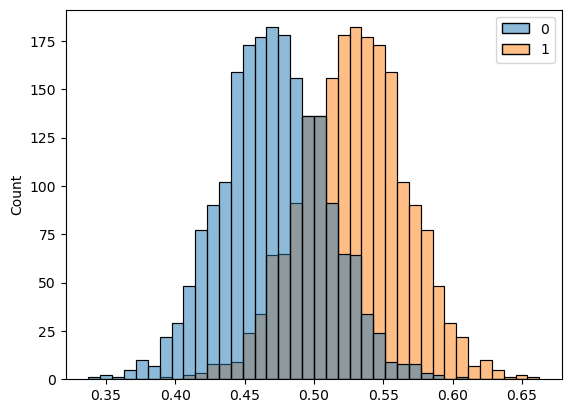

In [82]:
sns.histplot(samples_B2["vote_probs"][:,1])

In [85]:
num_votes_list = []
num_candidates_list = []
votes_list = []

for key, elect_df in county_elections.items():
  elect_df = elect_df.sort_values("votes")
  votes = jnp.array(elect_df["votes"])
  num_votes = jnp.sum(votes)
  num_candidates = len(votes)

  votes_list.append(votes)
  num_votes_list.append(num_votes.item())
  num_candidates_list.append(num_candidates)

# votes_array = jnp.stack(votes_list)
num_votes_array = jnp.array(num_votes_list)
num_candidates_array = jnp.array(num_candidates_list)

In [117]:
def model_B3(num_votes_array = None, votes_1 = None, votes_2 = None):
  alpha = numpyro.sample("alpha", dist.Exponential(rate = 0.02))
  vote_probs_1 = numpyro.sample("vote_probs_1", dist.Dirichlet(jnp.full([4], alpha)))
  vote_probs_2 = numpyro.sample("vote_probs_2", dist.Dirichlet(jnp.full([6], alpha)))

  observed_votes_1 = numpyro.sample("observed_votes_1", dist.Multinomial(total_count = num_votes_array[0], probs = vote_probs_1), obs=votes_1)
  observed_votes_2 = numpyro.sample("observed_votes_2", dist.Multinomial(total_count = num_votes_array[1], probs = vote_probs_2), obs=votes_2)


In [118]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_B3)
num_samples = 2_000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_,
    num_votes_array = num_votes_array,
    votes_1 = votes_list[0],
    votes_2 = votes_list[1]
)
mcmc.print_summary()
samples_B3 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:09<00:00, 308.84it/s, 7 steps of size 4.78e-01. acc. prob=0.92] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          alpha     55.18     36.95     46.52     10.17    101.90   1124.33      1.00
vote_probs_1[0]      0.22      0.02      0.22      0.18      0.25   2154.53      1.00
vote_probs_1[1]      0.25      0.02      0.25      0.21      0.28   2914.91      1.00
vote_probs_1[2]      0.26      0.02      0.25      0.22      0.29   3086.03      1.00
vote_probs_1[3]      0.28      0.02      0.28      0.24      0.32   2111.05      1.00
vote_probs_2[0]      0.14      0.01      0.14      0.12      0.16   1863.26      1.00
vote_probs_2[1]      0.15      0.01      0.15      0.13      0.17   2486.15      1.00
vote_probs_2[2]      0.16      0.01      0.16      0.14      0.18   2902.94      1.00
vote_probs_2[3]      0.18      0.01      0.18      0.16      0.20   3312.99      1.00
vote_probs_2[4]      0.18      0.01      0.18      0.16      0.21   2584.35      1.00
vote_probs_2[5]      0.19      0.01      0.19      0.

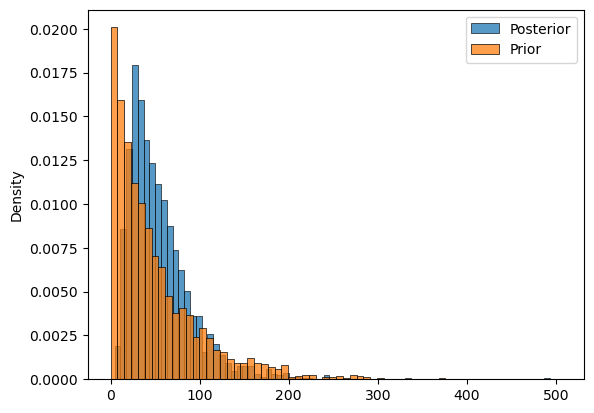

In [119]:
prior_predictive = Predictive(model_B3, num_samples = 3_000)
prior_predictions = prior_predictive(rng_key_, num_votes_array = num_votes_array, votes_1 = votes_list[0], votes_2 = votes_list[1])
sns.histplot(samples_B3["alpha"], label = "Posterior", stat="density")
sns.histplot(prior_predictions["alpha"], label = "Prior", stat="density")
plt.legend()
plt.show()

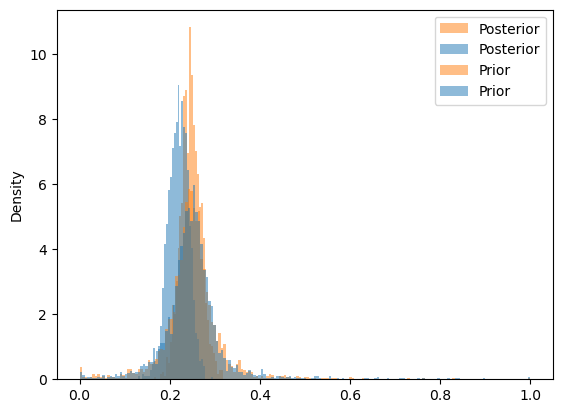

In [125]:
sns.histplot(samples_B3["vote_probs_1"][:, 0:2], label = "Posterior", stat="density", edgecolor=None)
sns.histplot(prior_predictions["vote_probs_1"][:, 0:2], label = "Prior", stat="density", edgecolor=None)
plt.legend()
plt.show()